# Import the libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, CLA, BlackLittermanModel
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import cvxpy as cp

In [ ]:
%matplotlib inline

# Download and Prepare Data

In [ ]:
def download_data(tickers, start_date, end_date):
    try:
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        if data.isnull().values.any():
            raise ValueError("Data contains null values. Please check the ticker symbols or date range.")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

def calculate_returns(data):
    returns = data.pct_change().dropna()
    return returns

def plot_data(data):
    data.plot(figsize=(10, 6))
    plt.title('Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend(loc='best')
    plt.show()


# Mean-Variance Optimization

In [ ]:
def mean_variance_optimization(data):
    try:
        mu = expected_returns.mean_historical_return(data)
        S = risk_models.sample_cov(data)
        ef = EfficientFrontier(mu, S)

        # Plotting the Efficient Frontier
        fig, ax = plt.subplots()
        plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
        plt.title('Efficient Frontier with Individual Assets')
        plt.xlabel('Risk')
        plt.ylabel('Return')
        plt.legend(loc='best')
        plt.show()

        # Optimize Portfolio
        ef = EfficientFrontier(mu, S)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        performance = ef.portfolio_performance(verbose=True)
        performance_metrics = ef.portfolio_performance(verbose=False)

        return cleaned_weights, performance, performance_metrics
    except Exception as e:
        print(f"Error in mean-variance optimization: {e}")
        return None, None, None

def plot_weights(weights, title):
    plt.figure(figsize=(10, 6))
    plt.bar(weights.keys(), weights.values())
    plt.title(title)
    plt.xlabel('Assets')
    plt.ylabel('Weights')
    plt.show()



# Black-Litterman Model

In [ ]:
def black_litterman_optimization(data, market_caps, Q, P):
    try:
        # Ensure Q and P are numpy arrays
        Q = np.array(Q)
        P = np.array(P)

        S = risk_models.sample_cov(data)
        bl = BlackLittermanModel(S, pi="market", market_caps=market_caps)
        bl_views = bl.bl_views(P, Q)
        bl_weights = bl.optimize()
        cleaned_weights = bl.clean_weights()
        performance = bl.portfolio_performance(verbose=True)

        return cleaned_weights, performance
    except Exception as e:
        print(f"Error in Black-Litterman optimization: {e}")
        return None, None



# Robust Optimization

In [ ]:
def robust_optimization(data):
    try:
        mu = expected_returns.mean_historical_return(data)
        S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        performance = ef.portfolio_performance(verbose=True)

        return cleaned_weights, performance
    except Exception as e:
        print(f"Error in robust optimization: {e}")
        return None, None



# Compare Different Optimization Techniques

In [ ]:
def compare_performance(performances):
    performance_df = pd.DataFrame(performances, index=["Expected Return", "Volatility", "Sharpe Ratio"])
    print("Performance Comparison")
    print(performance_df)

    # Plot performance comparison
    performance_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Performance Comparison of Different Optimization Techniques')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=0)
    plt.show()


# Portofolio Allocation

In [ ]:
def portfolio_allocation(weights, data, total_portfolio_value):
    latest_prices = get_latest_prices(data)
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=total_portfolio_value)
    allocation, leftover = da.lp_portfolio()
    print("Discrete allocation:", allocation)
    print("Funds remaining: ${:.2f}".format(leftover))


# Monte Carlo Simulation

In [ ]:
def monte_carlo_simulation(data, num_simulations=1000):
    try:
        returns = calculate_returns(data)
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        num_assets = len(mean_returns)

        results = np.zeros((3, num_simulations))
        weights_record = []

        for i in range(num_simulations):
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            weights_record.append(weights)

            portfolio_return = np.sum(weights * mean_returns) * 252
            portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
            sharpe_ratio = portfolio_return / portfolio_std_dev

            results[0,i] = portfolio_return
            results[1,i] = portfolio_std_dev
            results[2,i] = sharpe_ratio

        return results, weights_record
    except Exception as e:
        print(f"Error in Monte Carlo simulation: {e}")
        return None, None

def plot_monte_carlo_simulation(results):
    plt.figure(figsize=(10, 6))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.title('Monte Carlo Simulation: Portfolio Optimization')
    plt.show()


# Scenario Analysis

In [ ]:
def scenario_analysis(data, scenarios, risk_free_rate=0.01):
    try:
        scenario_results = {}
        returns = calculate_returns(data)
        cov_matrix = returns.cov()

        for scenario, scenario_return in scenarios.items():
            mu = pd.Series(scenario_return, index=returns.columns)

            # Ensure at least one return exceeds the risk-free rate
            if all(mu <= risk_free_rate):
                print(f"Skipping {scenario} as no returns exceed the risk-free rate.")
                continue

            ef = EfficientFrontier(mu, cov_matrix, weight_bounds=(0, 1))
            ef.add_objective(lambda w: w.T @ cov_matrix @ w)
            ef.max_sharpe(risk_free_rate=risk_free_rate)
            weights = ef.clean_weights()
            performance = ef.portfolio_performance(verbose=True)
            scenario_results[scenario] = (weights, performance)

        return scenario_results
    except Exception as e:
        print(f"Error in scenario analysis: {e}")
        return None



def plot_scenario_analysis(scenario_results):
    for scenario, (weights, performance) in scenario_results.items():
        plot_weights(weights, f'{scenario} Scenario Optimization Weights')
        plot_portfolio_performance(performance)


# Portfolio Performance

In [ ]:
def plot_portfolio_performance(performance):
    labels = ['Expected Annual Return', 'Annual Volatility', 'Sharpe Ratio']
    values = [performance[0], performance[1], performance[2]]
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'orange', 'green'])
    plt.title('Portfolio Performance')
    plt.ylabel('Value')
    plt.show()

def calculate_additional_metrics(returns):
    # Volatility
    volatility = returns.std() * np.sqrt(252)

    # Value at Risk (VaR)
    var_95 = np.percentile(returns, 5)

    # Conditional Value at Risk (CVaR)
    cvar_95 = returns[returns <= var_95].mean()

    return volatility, var_95, cvar_95

def display_additional_metrics(volatility, var_95, cvar_95):
    print(f"Annual Volatility: {volatility}")
    print(f"Value at Risk (95% confidence): {var_95}")
    print(f"Conditional Value at Risk (95% confidence): {cvar_95}")


# Main Execution

Enter tickers separated by commas (e.g., 'TSLA,BLK,NVDA,AAPL,MSCI'): TSLA,BLK,NVDA,AAPL,MSCI
Enter start date (YYYY-MM-DD): 2015-01-01
Enter end date (YYYY-MM-DD): 2024-08-01
Enter total portfolio value: 1000000


[*********************100%%**********************]  5 of 5 completed


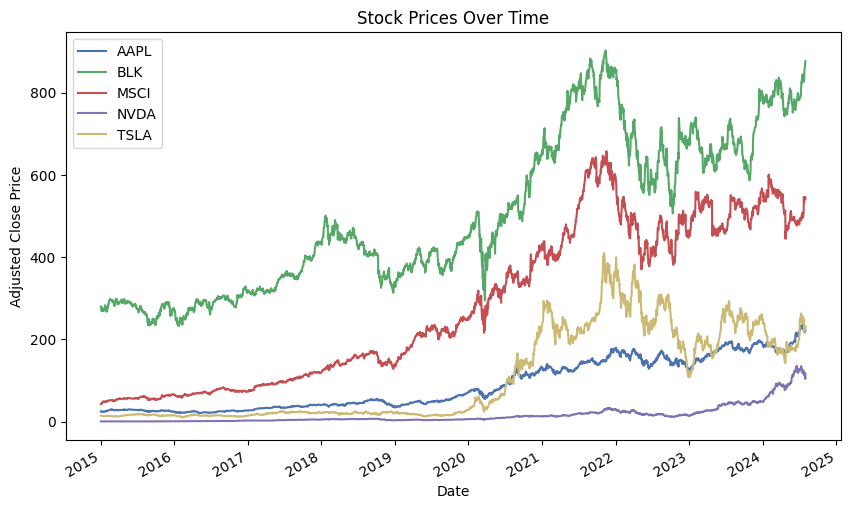

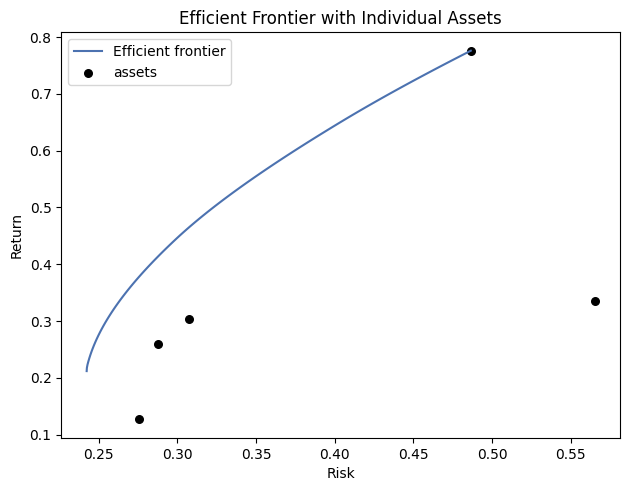

Expected annual return: 68.9%
Annual volatility: 42.8%
Sharpe Ratio: 1.56


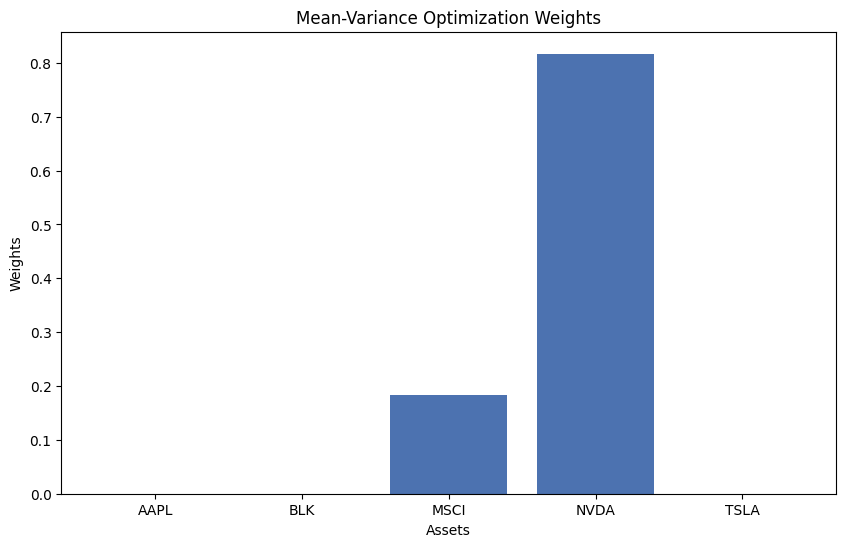

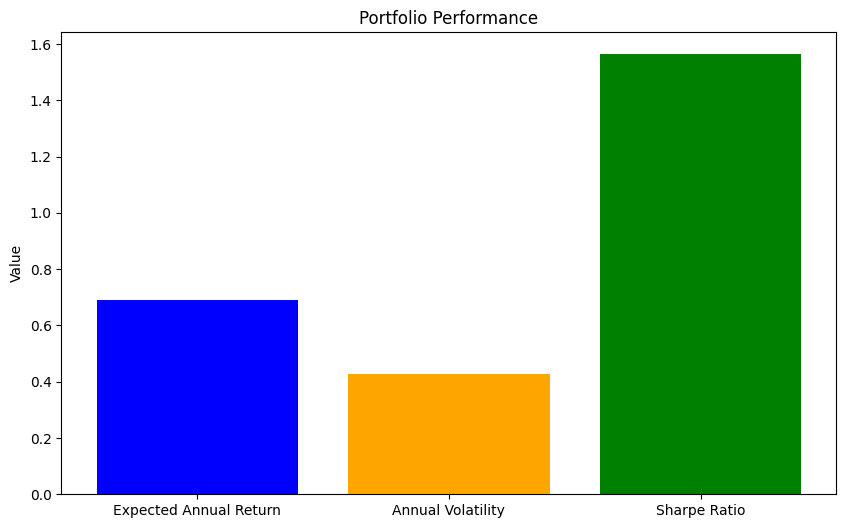

Annual Volatility: Ticker
AAPL    0.287851
BLK     0.275346
MSCI    0.307481
NVDA    0.486511
TSLA    0.565123
dtype: float64
Value at Risk (95% confidence): -0.0364021563759747
Conditional Value at Risk (95% confidence): Ticker
AAPL   -0.051462
BLK    -0.054188
MSCI   -0.052335
NVDA   -0.056273
TSLA   -0.061365
dtype: float64
Error in Black-Litterman optimization: Q must be an array or dataframe
Expected annual return: 68.8%
Annual volatility: 42.7%
Sharpe Ratio: 1.57


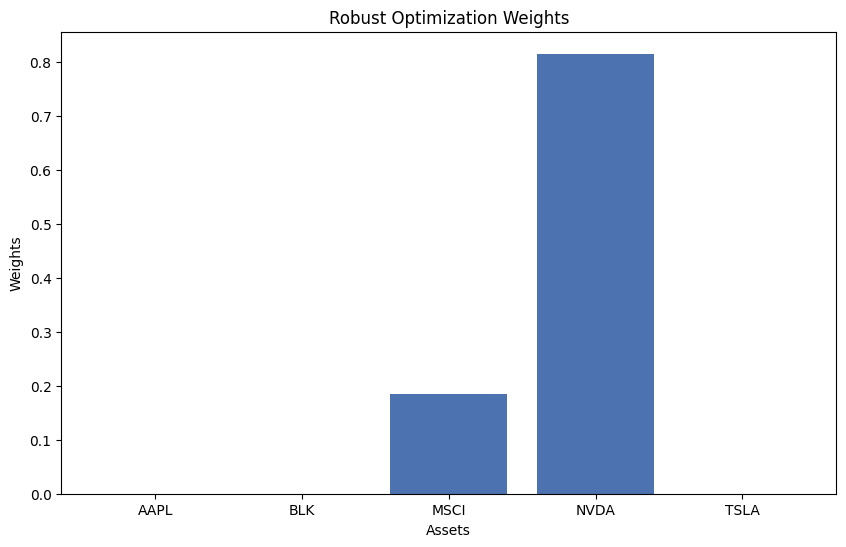

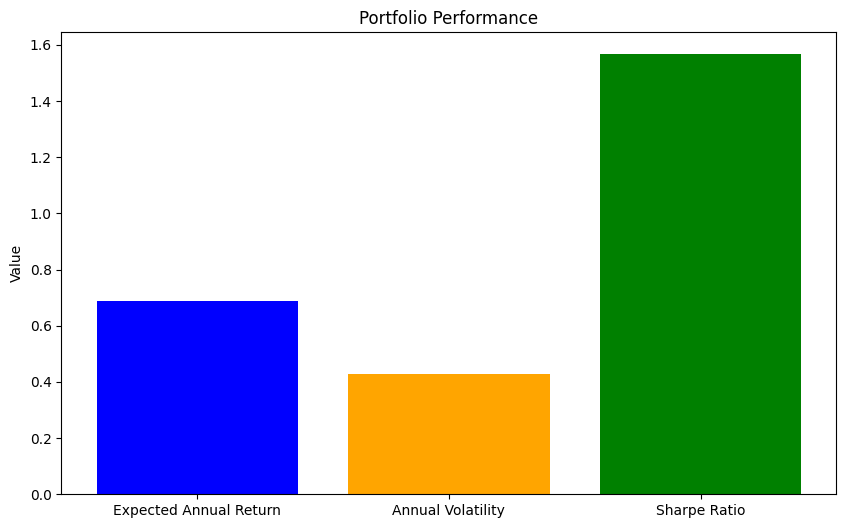

Annual Volatility: Ticker
AAPL    0.287851
BLK     0.275346
MSCI    0.307481
NVDA    0.486511
TSLA    0.565123
dtype: float64
Value at Risk (95% confidence): -0.0364021563759747
Conditional Value at Risk (95% confidence): Ticker
AAPL   -0.051462
BLK    -0.054188
MSCI   -0.052335
NVDA   -0.056273
TSLA   -0.061365
dtype: float64


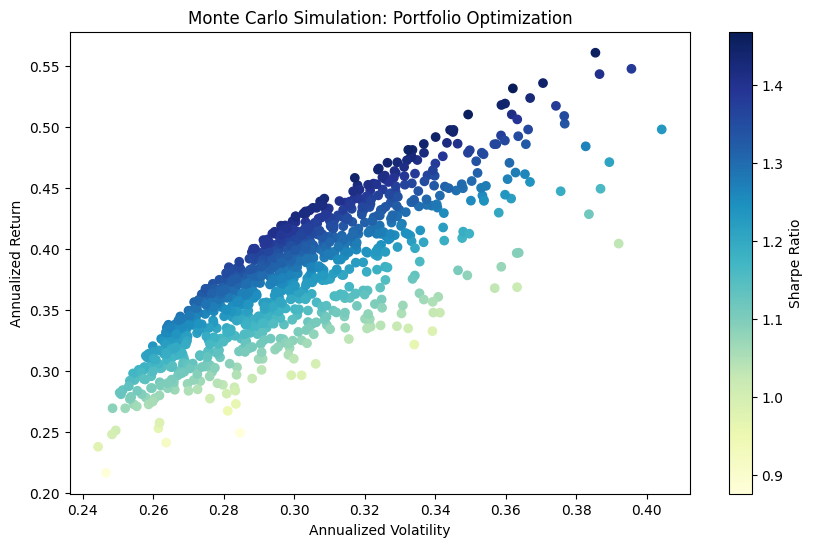

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


Expected annual return: 10.0%
Annual volatility: 1.5%
Sharpe Ratio: 5.90
Skipping Bear Market as no returns exceed the risk-free rate.


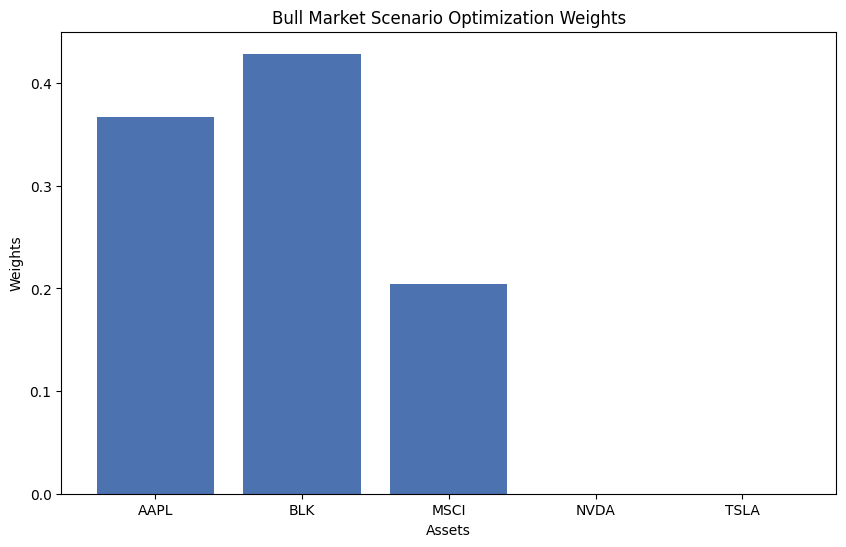

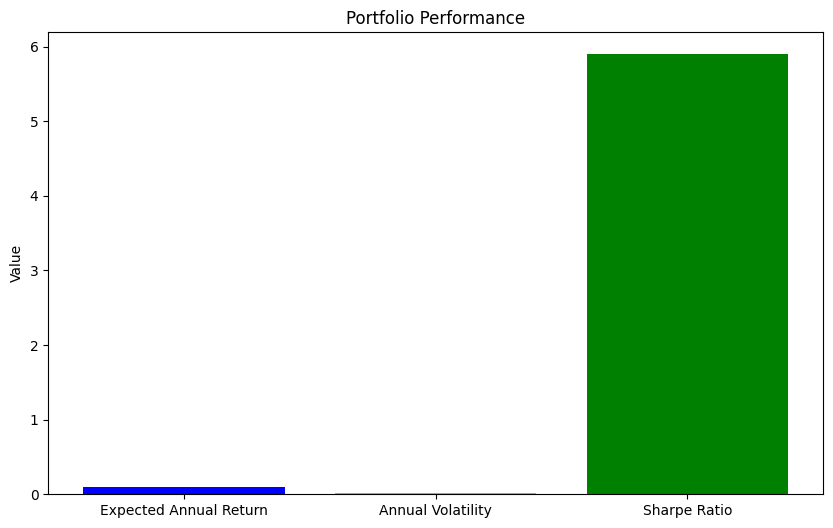

In [ ]:
def main():
    tickers = input("Enter tickers separated by commas (e.g., 'TSLA,BLK,NVDA,AAPL,MSCI'): ").split(',')
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")
    total_portfolio_value = float(input("Enter total portfolio value: "))

    # Download and prepare data
    data = download_data(tickers, start_date, end_date)
    if data is not None:
        plot_data(data)
        returns = calculate_returns(data)

        # Mean-Variance Optimization
        mv_weights, mv_performance, mv_performance_metrics = mean_variance_optimization(data)
        if mv_weights is not None:
            plot_weights(mv_weights, 'Mean-Variance Optimization Weights')
            plot_portfolio_performance(mv_performance)
            volatility, var_95, cvar_95 = calculate_additional_metrics(returns)
            display_additional_metrics(volatility, var_95, cvar_95)

        # Black-Litterman Model
        market_caps = pd.Series([2.2e12, 1.7e12, 1.1e12, 1.6e12, 9.1e11], index=tickers)
        Q = np.array([0.05, 0.03])
        P = np.array([
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0]
        ])
        bl_weights, bl_performance = black_litterman_optimization(data, market_caps, Q, P)
        if bl_weights is not None:
            plot_weights(bl_weights, 'Black-Litterman Optimization Weights')
            plot_portfolio_performance(bl_performance)
            volatility, var_95, cvar_95 = calculate_additional_metrics(returns)
            display_additional_metrics(volatility, var_95, cvar_95)

        # Robust Optimization
        rob_weights, rob_performance = robust_optimization(data)
        if rob_weights is not None:
            plot_weights(rob_weights, 'Robust Optimization Weights')
            plot_portfolio_performance(rob_performance)
            volatility, var_95, cvar_95 = calculate_additional_metrics(returns)
            display_additional_metrics(volatility, var_95, cvar_95)

        # Monte Carlo Simulation
        mc_results, mc_weights_record = monte_carlo_simulation(data)
        if mc_results is not None:
            plot_monte_carlo_simulation(mc_results)

        # Scenario Analysis
        scenarios = {
            'Bull Market': np.array([0.1, 0.1, 0.1, 0.1, 0.1]),
            'Bear Market': np.array([-0.1, -0.1, -0.1, -0.1, -0.1])
        }
        scenario_results = scenario_analysis(data, scenarios)
        if scenario_results is not None:
            plot_scenario_analysis(scenario_results)

# Run the main function
main()
